In [1]:
from numbers_parser import Document
import pandas as pd
import glob,os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

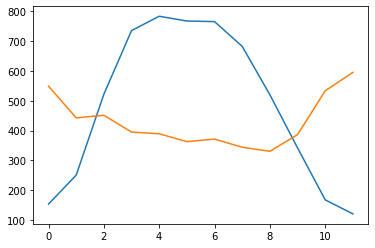

In [2]:
estimate=np.array([154,251,522,735,783,767,765,682,520,342,168,121])
used_2022=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
plt.plot(estimate)
plt.plot(used_2022)

In [3]:

now = str(1.8e3)
suffix = np.max([int(os.path.basename(x).replace('.csv','').split('_')[-1]) for x in glob.glob('/Users/manuel/Downloads/3693411*.csv')]).astype(str)
fn = f'/Users/manuel/Downloads/3693411_system_energy_20221218_to_{suffix}.csv'
produced = pd.read_csv(fn).rename(columns={'Date/Time':'Date','Energy Produced (Wh)':'Produced'})
produced=produced.head(produced.shape[0]-1)

produced['Date']=pd.to_datetime(produced['Date'])
produced['Date']=produced['Date']+pd.Timedelta(days=1)

d=pd.Timestamp('now')
d=pd.Timestamp(d.year,d.month,d.day,d.hour,d.minute)

produced=produced.append({'Date':d,'Produced':now},ignore_index=True)
produced['Produced']=[float(x.replace(',',''))/1000 for x in produced['Produced'].values]
d0 = produced['Date'].min()
t_produced = ((produced['Date'] - d0)/pd.Timedelta(days=1)).values

produced.tail(5)

,Date,Produced
162,2023-05-30 00:00:00,37.194
163,2023-05-31 00:00:00,29.815
164,2023-06-01 00:00:00,38.799
165,2023-06-02 00:00:00,25.156
166,2023-06-02 10:04:00,1.800


In [4]:
produced['Produced'].sum()

2286.541

In [5]:
try:
    doc = Document("/Users/manuel/Library/Mobile Documents/com~apple~Numbers/Documents/Zonnepanelen.numbers")
    sheets = doc.sheets()

    s = sheets['Electricity']

    data = s.tables['Inputs'].rows(values_only=True)
    meter = pd.DataFrame(data[1:], columns=data[0])[['Date ', 'Meter']]
    meter['Date']=[x.replace(tzinfo=None) for x in meter['Date ']]
    meter.to_csv('meter.csv',index=False)
except:
    print('not in the mac')

meter = pd.read_csv('meter.csv')
meter['Date'] =pd.to_datetime(meter['Date'])
t_meter = ((meter['Date']-d0)//pd.Timedelta(seconds=1)).values/(24*3600)
f_meter= interp1d(t_meter,meter['Meter'].values,fill_value='extrapolate')

TypeError: argument of type 'method' is not iterable

In [ ]:
produced['Meter'] = f_meter(t_produced)
produced['Net Used'] = produced['Meter'].diff(1)
produced['Total Used']=produced['Net Used']+produced['Produced']

diff = np.maximum(produced['Total Used'],0)-produced['Total Used']
produced['Produced']=diff+produced['Produced']
produced['Total Used']=produced['Net Used']+produced['Produced']
#produced['Total Used']=produced['Net Used']+produced['Produced']


produced['Since']=[produced.loc[produced['Meter'].values>=m,'Date'].min() for m in produced['Meter']]
produced['Year'] = [x.year for x in produced['Date']]
produced['Month'] = [x.month for x in produced['Date']]
#produced.loc[produced['Produced']<2]
produced.tail(10)

,Date,Produced,Meter,Net Used,Total Used,Since,Year,Month
157,2023-05-25 00:00:00,25.342000,29164.652949,-13.484980,11.857020,2023-01-26,2023,5
158,2023-05-26 00:00:00,26.762000,29148.132471,-16.520478,10.241522,2023-01-26,2023,5
159,2023-05-27 00:00:00,39.160000,29125.478088,-22.654383,16.505617,2023-01-24,2023,5
160,2023-05-28 00:00:00,38.047000,29101.070851,-24.407237,13.639763,2023-01-23,2023,5
161,2023-05-29 00:00:00,33.567000,29077.523034,-23.547818,10.019182,2023-01-21,2023,5
162,2023-05-30 00:00:00,37.194000,29053.326652,-24.196382,12.997618,2023-01-20,2023,5
163,2023-05-31 00:00:00,29.815000,29030.849243,-22.477409,7.337591,2023-01-18,2023,5
164,2023-06-01 00:00:00,38.799000,29005.662359,-25.186884,13.612116,2023-01-17,2023,6
165,2023-06-02 00:00:00,25.156000,28985.807187,-19.855172,5.300828,2023-01-15,2023,6
166,2023-06-02 09:56:00,6.819583,28978.987604,-6.819583,0.000000,2023-01-15,2023,6


In [ ]:
meter.head(12)

,Date,Meter,Date
0,2022-12-22 00:00:00+00:00,28620.0,2022-12-22
1,2023-01-01 00:00:00+00:00,28781.0,2023-01-01
2,2023-01-08 00:00:00+00:00,28896.0,2023-01-08
3,2023-01-10 00:00:00+00:00,28907.0,2023-01-10
4,2023-01-19 00:00:00+00:00,29052.0,2023-01-19
5,2023-01-20 00:00:00+00:00,29058.0,2023-01-20
6,2023-01-21 00:00:00+00:00,29079.0,2023-01-21
7,2023-01-23 00:00:00+00:00,29113.0,2023-01-23
8,2023-01-25 00:00:00+00:00,29148.0,2023-01-25
9,2023-01-27 00:00:00+00:00,29182.0,2023-01-27


In [ ]:
per_month=produced[['Year','Month','Produced','Net Used','Total Used']].groupby(['Year','Month']).sum()
per_month

Produced    Net Used  Total Used
Year Month                                    
2022 12      19.339000  193.200000  212.539000
2023 1      131.255000  476.600000  607.855000
     2      236.186000  265.221220  501.407220
     3      393.108000  134.637749  527.745749
     4      596.593373 -137.927121  458.666252
     5      847.481000 -472.582606  374.898394
     6       70.774583  -51.861639   18.912945

Text(0.5, 1.0, 'Use')

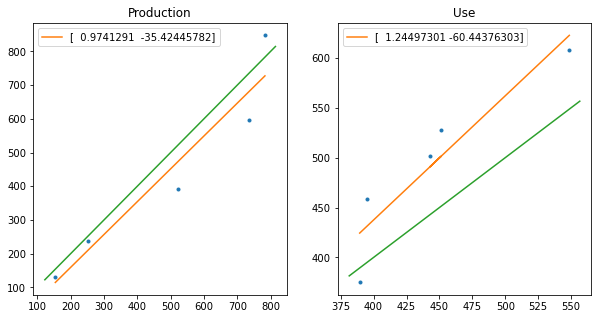

In [ ]:
i=5

total_used = per_month.loc[2023,:].loc[:i]['Total Used'].values
produced_ = per_month.loc[2023,:].loc[:i]['Produced'].values

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(estimate[:produced_.size],produced_,'.')
poly_produce = np.polyfit(estimate[:produced_.size],produced_,1)
plt.plot(estimate[:produced_.size],np.polyval(poly_produce,estimate[:produced_.size]),label=poly_produce)
xx = plt.gca().get_xlim()
plt.plot(xx,xx)
plt.title('Production')
plt.legend()

plt.subplot(1,2,2)

plt.plot(used_2022[:total_used.size],total_used,'.')
poly_use = np.polyfit(used_2022[:total_used.size],total_used,1)
plt.plot(used_2022[:total_used.size],np.polyval(poly_use,used_2022[:total_used.size]),label=poly_use)
xx = plt.gca().get_xlim()
plt.plot(xx,xx)
plt.legend()
plt.title('Use')

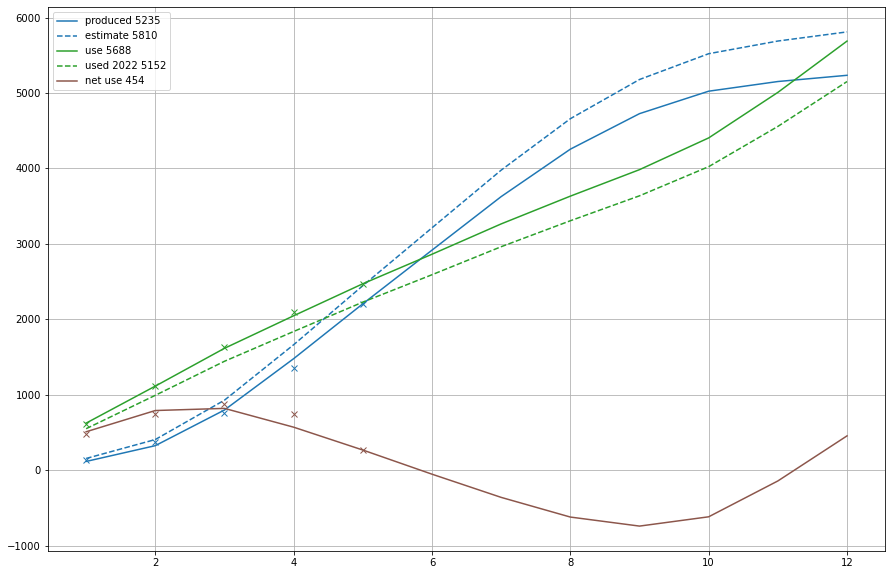

In [ ]:
plt.figure(figsize=(15,10))
x=np.arange(12)+1
xx = np.arange(i)+1



proj_prod = np.polyval(poly_produce,estimate)
plt.plot(x,proj_prod.cumsum(),label=f'produced {proj_prod.sum():0.0f}',color='C0')
plt.plot(xx,produced_.cumsum(),'x',color='C0')
plt.plot(x,estimate.cumsum(),label=f'estimate {estimate.sum():0.0f}',color='C0',ls='--')

proj_use=np.polyval(poly_use,used_2022)
plt.plot(x,proj_use.cumsum(),label=f'use {proj_use.sum():0.0f}',color='C2')
plt.plot(xx,total_used.cumsum(),'x',color='C2')
plt.plot(x,used_2022.cumsum(),label=f'used 2022 {used_2022.sum():0.0f}',color='C2',ls='--')

plt.plot(x,(proj_use-proj_prod).cumsum(),label=f'net use {(proj_use-proj_prod).sum():0.0f}',color='C5')
plt.plot(xx,(total_used-produced_).cumsum(),'x',color='C5')

plt.grid(True)
plt.legend()

In [ ]:
produced[['Year','Month','Produced','Net Used','Total Used']].groupby(['Year','Month']).mean()

Produced   Net Used  Total Used
Year Month                                  
2022 12      1.611583  16.100000   17.711583
2023 1       4.234032  15.374194   19.608226
     2       8.435214   9.472186   17.907401
     3      12.680903   4.343153   17.024056
     4      19.886446  -4.597571   15.288875
     5      27.338097 -15.244600   12.093497
     6      23.788829 -16.982771    6.806058

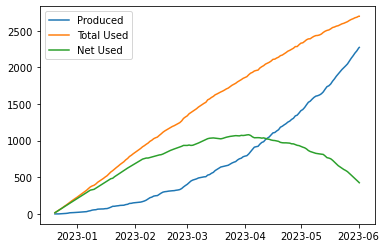

In [ ]:
x=produced['Date']

for col in ['Produced','Total Used','Net Used']:
    plt.plot(x,produced[col].cumsum(),label=col)
plt.legend()


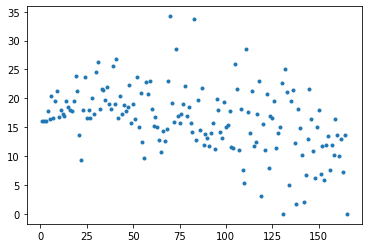

In [ ]:
#plt.hist(produced['Total Used'],20);
#plt.hist(produced['Produced'],50);
#plt.plot(produced['Meter'])
plt.plot(produced['Total Used'],'.')